# Adaptive Mesh Refinement and Surface Tension

Here, we adapt surface tension, and the corresponding mesh refinement methods, from 2D to 3D.

# Surface Tension in 3D. 

## Vertex-Oriented Derivation
We start by introducing the vertex-oriented formalism outlined in Peskin's Lecture (https://www.math.nyu.edu/~peskin/ib_lecture_notes/index.html). Let vertex $\vec{X}_{k}$ have $n(k)$ neighbors, labeled $v_i(k)$ in counter-clockwise order, so that $\vec{X}_k$, $\vec{X}_{v_i(k)}$, $\vec{X}_{v_{i+1}(k)}$ form a triangular face. $X_k$ and its neighbors form a tetrahedron with the origin, and the sum of these tetrahedra give the total volume of the trangulated surface

$V = \frac{1}{3}\sum_{k=0}^{N-1} \frac{1}{6}\sum_{i=0}^{n(k)-1} \vec{X}_k \cdot ( \vec{X}_{v_i(k)} \times \vec{X}_{v_{i+1}(k)}) $

Peskin's lecture notes that the sum of the signed volume is independent of origin, even if the origin lies outside of the triangulated surface. See the original lecture for details. 

We can also associate an area vector to each vertex as follows:

$\vec{A}_l = \frac{\partial V}{\partial \vec{X}_l} = \frac{\partial }{\partial \vec{X}_l}\frac{1}{6}  \sum_{i=0}^{n(l)-1} \vec{X}_l \cdot ( \vec{X}_{v_i(l)} \times \vec{X}_{v_{i+1}(l)}) = \frac{1}{6}  \sum_{i=0}^{n(l)-1} \vec{X}_{v_i(l)} \times \vec{X}_{v_{i+1}(l)}$

where we have used the fact that $\vec{X_l}$ changes the volume only of the tetrahedron which it forms with its neighbors. 

Next, suppose instead that instead of a list of neighbors, we instead have 

## Area of Triangular Faces Derivation

Let a triangulated surface consist of a set of vertices $\{\vec{X}_k\}_{k=0}^{N_b-1}$ and a set of triangular faces $\{v_i\}_{i=0}^{N_f-1}$, where each $v_i$ is a set of the three vertices $\{\vec{X}_{v_i(1)}, \vec{X}_{v_i(2)}, \vec{X}_{v_i(3)}\}$ which form a triangular face $i$. Each triangulated face makes a tetrahedron with the origin, and the sum of these tetrahedra give the total volume $V$ of the triangulated surface. Consequently, we can write 

$V = \frac{1}{6}\sum_{i=0}^{N_f-1}  \vec{X}_{v_i(1)} \cdot ( \vec{X}_{v_i(2)} \times \vec{X}_{v_{i+1}(3)}) $

This expression is similar to that derived in Peskin's vertex-oriented derivation (https://www.math.nyu.edu/~peskin/ib_lecture_notes/index.html), except that we sum over faces instead of over vertices and neighbors. 

Following Peskin's procedure, let us assign to each vertex the following area vector:

$\vec{A}_l = \frac{\partial V}{\partial \vec{X}_l} = \frac{\partial }{\partial \vec{X}_l}\frac{1}{6}\sum_{i=0}^{N_f-1}  \vec{X}_{v_i(1)} \cdot ( \vec{X}_{v_i(2)} \times \vec{X}_{v_{i+1}(3)}) $

To evaluate this expression, we first note that shifting $\vec{X}_l$ affects only the volume of adjacent tetrahedra, so we may sum over only the triangular faces which contain $X_{i}$, e.g. 

In [6]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import tri
from util import *

%matplotlib notebook 

from fluid3 import FLUID    #### Generic fluid solver
from ib3 import IB3         #### 3D Immersed Boundary object
import warnings; warnings.simplefilter('ignore')
from time import time

#### Iterate fluids and immersed solids using built-in functions
def iterate(fluid, solids):  
    ff = 0. ## Force density on fluid
    for solid in solids:
        solid.step_XX(fluid.u)
        ff += solid.ff # Force at midpoint
    uu=fluid.step_u(ff) # Step Fluid Velocity
    for solid in solids:
        solid.step_X(uu) # full step using midpoint velocity  
        

        


<IPython.core.display.Javascript object>


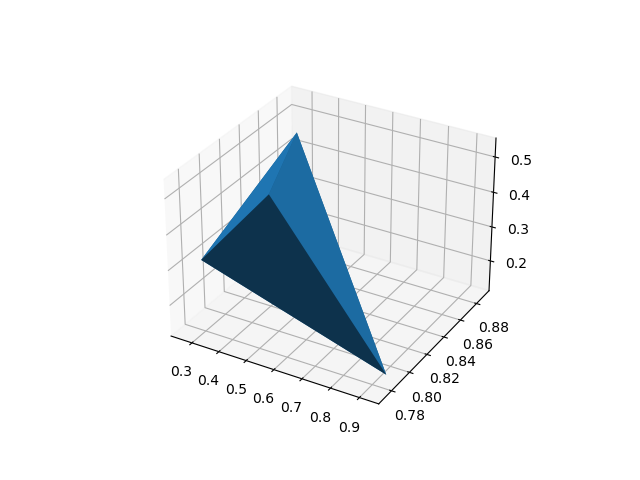

0.13252400475994333
0.1325240047599433
0.13252400475994336


In [16]:
X = [[0,0,0], [0,1,1], [1,1,0], [1,1,1]]
v = [[0,1,2], [0,2,3], [0,3,1], [1,2,3] ]
X = np.array(X)

X = np.random.random([4,3])
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_trisurf(*[X[:,i] for i in range(3)], triangles=v)


print(np.dot(X[0], np.cross(X[1], X[2])))
print(np.dot(X[1], np.cross(X[2], X[0])))
print(np.dot(X[2], np.cross(X[0], X[1])))


## Surface Tension in 3D
In 3D, the surface energy is proportional to the total surface area;
$E[\{ \vec{X}_i\} ] = \gamma \sum_{i=0}^N ||\vec{X_i} - \vec{X}_{i-1}||$

where $\gamma$ is surface energy per unit length, and we let $\vec{X}_{-1} \equiv \vec{X}_N$ to express the energy functional in a more concise and pythonic manner. Then, 



$\vec{F}_j = \frac{\delta E[ \{ \vec{X}_i\} ]}{\delta \vec{X}_j} = \gamma \Bigg[ \frac{\partial ||\vec{X}_j - \vec{X}_{j-1}||}{\partial \vec{X}_j} + \frac{\partial ||\vec{X}_{j+1} - \vec{X}_j||}{\partial \vec{X}_j }\Bigg] $


$= \gamma \Bigg[ \frac{\vec{X}_j - \vec{X}_{j-1}}{||\vec{X}_j - \vec{X}_{j-1}||} -\frac{\vec{X}_{j+1} - \vec{X}_j}{||\vec{X}_{j+1} - \vec{X}_j|| }\Bigg]$

which is the difference of two unit vectors, and always points tangential to the surface. Let's start by subclassing IB2 with this Force, and adding a few methods to be explained later:

In [107]:
#### Script for IBM simulation of a single droplet in incompressible, periodic fluid
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import gridspec

%matplotlib notebook 

from fluid2 import FLUID    #### Generic fluid solver
from ib3 import IB3         #### 2D Immersed Boundary object (droplet membrane)
# from ib2_amr import IB2 as IB2_AMR         #### 2D Immersed Boundary object (droplet membrane)
from util import *          #### General functions (iterate, geometry, force functions, etc)
import warnings; warnings.simplefilter('ignore')

from IPython.display import display


class IB3_AMR(IB3):
    
    def Force(self, X):
        K, kp, km = self.K, self.kp, self.km
        dX = X - X[km]
        lX = np.linalg.norm(dX, axis=1)
        return self.K*(dX[kp]/lX[kp, np.newaxis] - dX/lX[:, np.newaxis])/(self.dtheta)
    
    def split_X(self, indices):
        indices.sort(reverse=True)
        X = [x for x in self.X]  ## It's ~10x faster to convert to list and use python insert than to use numpy insert
        for i in indices:    X.insert(i, 0.5*(X[i] + X[i-1]))
        self.X = np.vstack(X)
        self.Nb = self.Nb + len(indices)
        
        
    def merge_X(self, indices):
        indices.sort(reverse=True)
        X = [x for x in self.X]  ## It's ~10x faster to convert to list and use python insert than to use numpy insert
        for i in indices:    
#             X[i-1] = 0.5*(X[i] + X[i-1])
            del X[i]
        self.X = np.vstack(X)
        self.Nb = self.Nb - len(indices)
        
    def adj_X(self, split, merge):
        self.split_X(split)
#         split.sort(reverse=True) # unnecessary because split_X sorts indices
        merge = np.array(merge)
        for i in split: merge[merge>i] +=1
        merge = list(merge)
        self.merge_X(merge)
        
    def step_XX(self, u): 
#         lX = np.linalg.norm(self.X - self.X[self.km], axis=1)
#         ii = self.km+1
#         self.adj_X(list(ii[lX>0.3*self.h]), list(ii[lX<0.03*self.h]))
        super(IB2_AMR, self).step_XX(u)
   
    @property
    def dtheta(self): return 1.

# Circular Membrane in Stationary Fluid

To test our force functional, let's take a simple case and look at the surface tension forces. We also ought to  check that the total force exerted on the fluid converges as the number of boundary points is increased.  

<IPython.core.display.Javascript object>


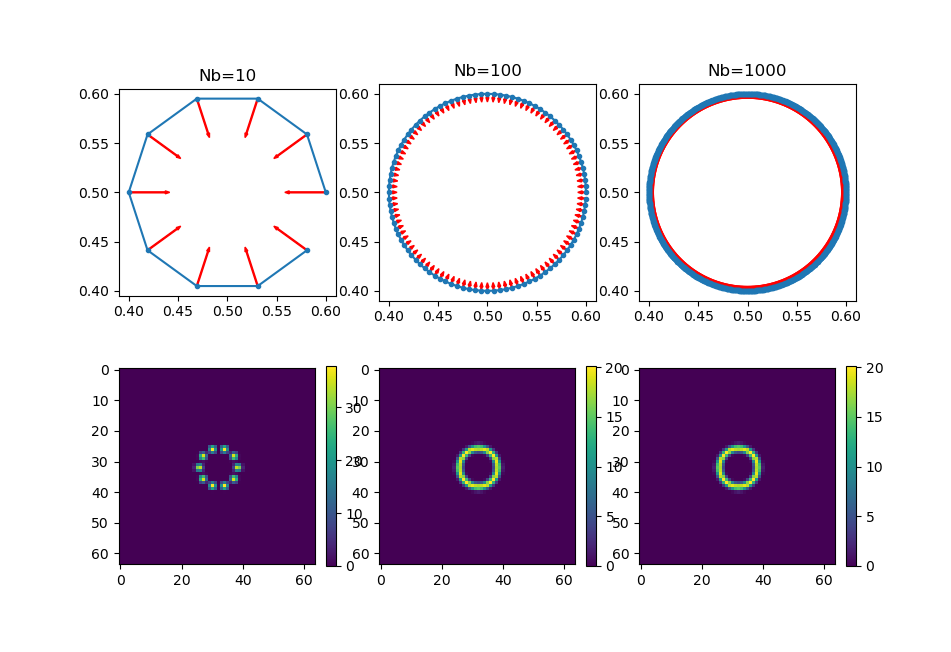

Maximum Force Density: 0.03708203932499376
Total Force on Fluid: 1518.8732517815224

Maximum Force Density: 0.003769291089376993
Total Force on Fluid: 1533.9785068294002

Maximum Force Density: 0.00037699049832569815
Total Force on Fluid: 1534.2283209011057



In [2]:
def CIRCLE(RAD=1., POS=(0.,0.), Nb=100):  
    theta = np.linspace(0, 2*np.pi, Nb+1)[:-1]
    return RAD*np.stack([np.cos(theta), np.sin(theta)], axis=1) + POS

fluid = FLUID()
fig = plt.figure()

rad=.1
Nb_vals = [10, 100, 1000]
NNb = len(Nb_vals)

def plot_force(s, ax, ax2=None):
    ax.plot(s.X[:,0], s.X[:,1], marker='.')
    ax.set_aspect('equal', 'box')
    F = s.Force(s.X)*.06
    print('Maximum Force Density: {}'.format(np.max(np.linalg.norm(F, axis=1))))
    for i, x in enumerate(s.X): ax.arrow(x[0], x[1], F[i][0], F[i][1], color='red', linewidth=1)
    f = np.linalg.norm(s.vec_spread(F, s.X), axis=0).transpose()
    # f*=(Nb*fluid.h)**(-1)
    c = ax2.imshow(f)
    plt.colorbar(c, ax=ax2, fraction=0.046)
    print('Total Force on Fluid: {}'.format(np.sum(f)))
    print()
    return f
    
for ii, Nb in enumerate(Nb_vals):
#     s = IB2( CIRCLE(rad, [0.5,0.5], Nb), fluid.N, fluid.h, fluid.dt, K=10) 
    s = IB2_AMR( CIRCLE(rad, [0.5,0.5], Nb), fluid.N, fluid.h, fluid.dt) 
    
#     ax = fig.add_subplot(NNb, 2, 2*ii+1)
#     ax2 = fig.add_subplot(NNb, 2, 2*ii+2)
    ax = fig.add_subplot(2, NNb, ii+1)
    ax.set_title('Nb={}'.format(Nb))
    ax2 = fig.add_subplot(2, NNb, ii+4)
    
    f = plot_force(s, ax, ax2)
    
f_unif = f.copy()

Note that the force exerted on the fluid becomes "disjoint" when there are only a few boundary points, but "smooths" out when the spacing between points becomes comparable to the grid spacing. Also note from the colorbar that the the total force exerted on the fluid approaches a finite value as the number of boundary points increases. 

Also note that as the number of boundary points $N_b \xrightarrow{} \infty$, the force on each point $\vec{F} \xrightarrow{} 0$.As discussed in a paper on Osmotic Swelling by Wu, Peskin et all (https://www.researchgate.net/publication/281719583_Simulation_of_Osmotic_Swelling_by_the_Stochastic_Immersed_Boundary_Method/link/5ce847faa6fdccc9ddccce58/download) this occurs because we define $\vec{F}$ as the Force, rather than the Force Density. As the number of boundary points increases, the force from each boundary point decreases such that the force per unit area of fluid (length of boundary) remains constant.

We can see this phenomenon directly in our code through the variable $d\theta$ 
Our surface tension force in the code above has a dependence $\vec{F} \propto 1/d\theta$, but also note that the spreading operator in the base class ib2.py includes a factor of $d\theta /h^2$. By our current convention, we set $d\theta=1$, which results in the behavior described above. By contrast, if we instead let $d\theta = 2\pi/N_b$, we would note that the red force vectors $F$ would remain *constant* as $N_b \xrightarrow{} \infty$, but the total force on the fluid (sum of the spreaded force density) would still converge to a finite value.  In particular, in this case, this factor of $d\theta$ *must* cancel upon applying the spreading operator if $d\theta$ has any dependence on $N_b$ (which it often does), otherwise the total force would not converge and the system would not be physical. 

We may also plot the maximum/total force as a function of various $N_b$, $r$:

<IPython.core.display.Javascript object>


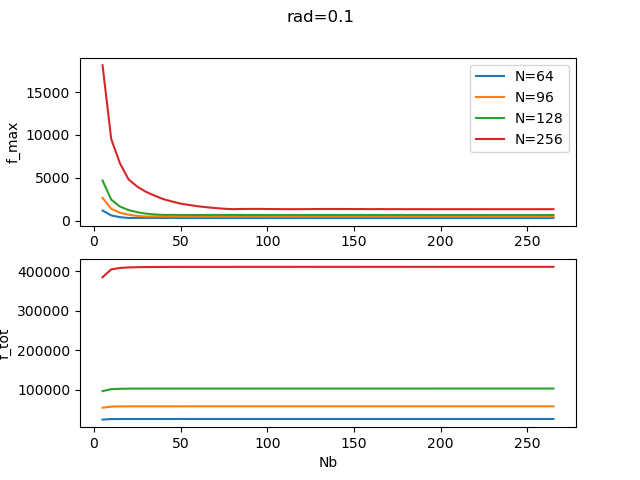

<IPython.core.display.Javascript object>


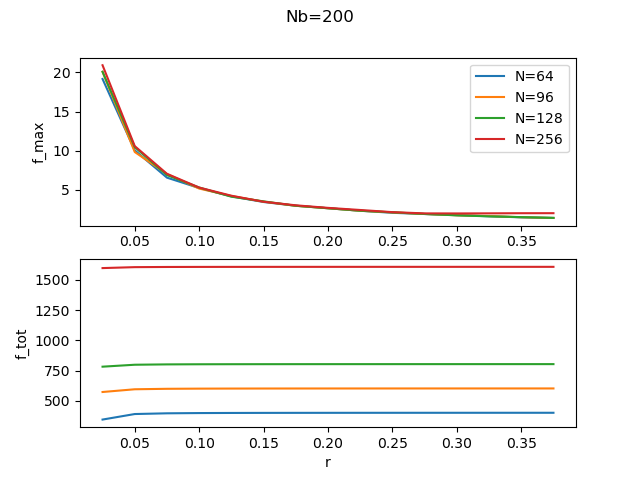

Text(0.5, 0.98, 'Nb=200')

In [176]:
Nb_vals = np.arange(5, 270, 5)
rad=0.1

fig = plt.figure()
ax1 = plt.subplot(2,1,1)
ax1.set_ylabel('f_max')
ax2 = plt.subplot(2,1,2)
ax2.set_xlabel('Nb')
# ax2.set_xlabel('r dtheta / h')
ax2.set_ylabel('f_tot')

for N in [64, 96, 128, 256]:
    fluid = FLUID(N=N)
    f_max = []
    f_tot = []
    for Nb in Nb_vals:
        
        s = IB2_AMR( CIRCLE(rad, [0.5,0.5], Nb), fluid.N, fluid.h, fluid.dt) 
        F = s.Force(s.X)*fluid.h
        f = np.linalg.norm(s.vec_spread(F, s.X), axis=0).transpose()
        f_max.append(np.max(f))
        f_tot.append(np.sum(f))

    ax1.plot(Nb_vals, f_max, label='N={}'.format(N))
    ax2.plot(Nb_vals, f_tot)
#     ax1.plot( (2*np.pi*rad/Nb_vals)/fluid.h, f_max, label='N={}'.format(N))
#     ax2.plot( (2*np.pi*rad/Nb_vals)/fluid.h, f_tot)
    # fig.suptitle('rad={}, N={}'.format(rad, N))
ax1.legend()
fig.suptitle('rad={}'.format(rad))



rad_vals = np.arange(0.025, 0.4, 0.025)
Nb=200

fig = plt.figure()
ax1 = plt.subplot(2,1,1)
ax1.set_ylabel('f_max')
ax2 = plt.subplot(2,1,2)
# ax2.set_xlabel('Nb')
ax2.set_xlabel('r')
# ax2.set_xlabel('r dtheta / h')
ax2.set_ylabel('f_tot')

for N in [64, 96, 128, 256]:
    fluid = FLUID(N=N)
    f_max = []
    f_tot = []
    for rad in rad_vals:
        
        s = IB2_AMR( CIRCLE(rad, [0.5,0.5], Nb), fluid.N, fluid.h, fluid.dt) 
        F = s.Force(s.X)*fluid.h
        f = np.linalg.norm(s.vec_spread(F, s.X), axis=0).transpose()
        f_max.append(np.max(f))
        f_tot.append(np.sum(f))

    ax1.plot(rad_vals, f_max, label='N={}'.format(N))
    ax2.plot(rad_vals, f_tot)
#     ax1.plot( (2*np.pi*rad/Nb_vals)/fluid.h, f_max, label='N={}'.format(N))
#     ax2.plot( (2*np.pi*rad/Nb_vals)/fluid.h, f_tot)
    # fig.suptitle('rad={}, N={}'.format(rad, N))
ax1.legend()
fig.suptitle('Nb={}'.format(Nb))




# Non-Circular Boundaries and Mesh Refinement

What do forces look like on a non-circular boundary? We can try and find out by modulating the radius of the circle; i.e. looking at the curve

$ R(\theta) = R_0(1+A\sin{n\theta})$

Note that for non-integer $n$, $R(0) \neq R(2\pi)$ and $R(\theta)$ is not periodic. Some examples and the corresponding forces are shown below:

<IPython.core.display.Javascript object>


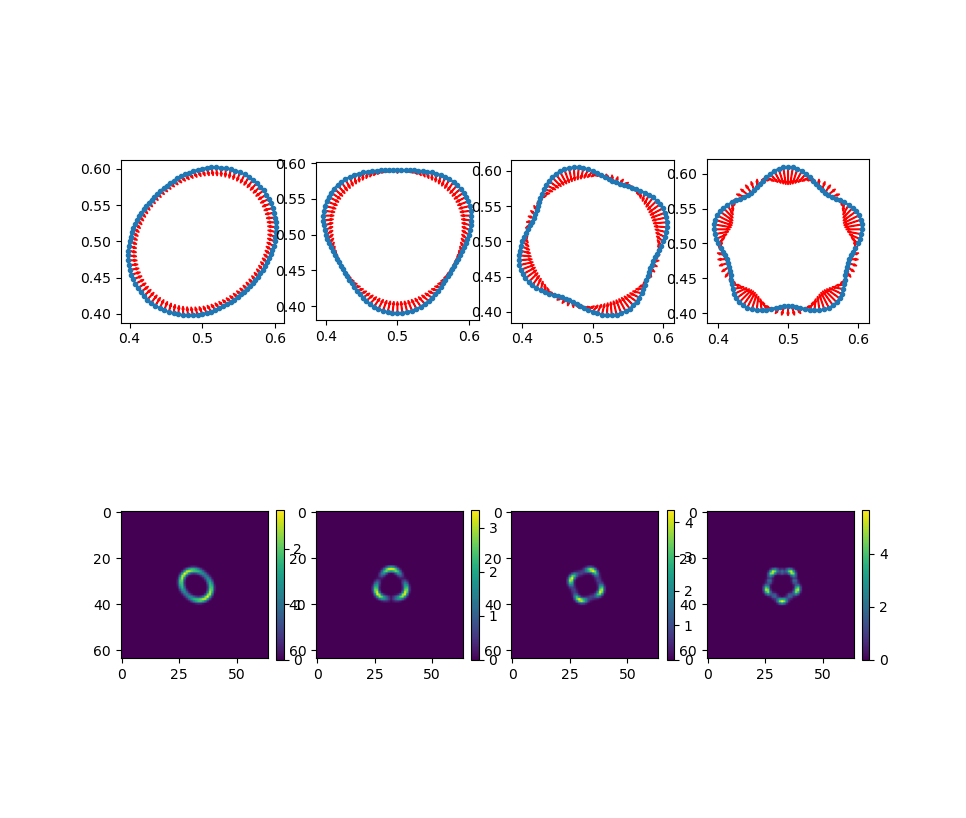

Maximum Force Density: 0.008985294383876762
Total Force on Fluid: 159.15326829878666

Maximum Force Density: 0.011971234984265697
Total Force on Fluid: 166.88703089261548

Maximum Force Density: 0.01611132551962119
Total Force on Fluid: 200.9166844564994

Maximum Force Density: 0.021445507643971642
Total Force on Fluid: 257.2542399182299



In [98]:
def MOD_CIRCLE(RAD=1., POS=(0.,0.), Nb=100, modA=0.1, n=4):
    theta = np.linspace(0, 2*np.pi, Nb+1)[:-1]
    RAD += RAD*modA*np.sin(theta*n)
    return RAD[:, np.newaxis]*np.stack([np.cos(theta), np.sin(theta)], axis=1) + POS

f_vals = [2, 3, 4, 5]
Nf = len(f_vals)
fig = plt.figure()
for ii, f in enumerate(f_vals):
#     s = IB2_AMR( MOD_CIRCLE(0.1, [0.5,0.5], 100, modF=f), fluid.N, fluid.h, fluid.dt) 
    s = IB2( MOD_CIRCLE(0.1, [0.5,0.5], 100, n=f), fluid.N, fluid.h, fluid.dt, K=1) 
    
    ax = fig.add_subplot(2,Nf,ii+1)
    ax2 = fig.add_subplot(2, Nf, ii+5)
    ax.set_aspect('equal', 'box')
    ax2.set_aspect('equal', 'box')
    plot_force(s, ax, ax2)

    
    


These examples clearly show that surface tension is higher in regions with large curvature. 

## Caveat

The diagrams above give us a good idea of the surface tension forces, but there is a small caveat which we have not yet considered. We have already seen that the spacing of boundary points may affect the corresponding surface tension force of those points. So long as the spacing remains small enough that the force density is fully resolved, this does not affect the force exerted locally on the fluid, (is this true)? , and the spacing does not have any physical affects (is THIS true?). However, the red force vectors in the diagrams above may be misleading.

To more clearly see this affect at play, let's take a look a circle with non-uniformly spaced boundary points. For comparison, let's also plot two uniformly spaced circles corresponding to the largest and smallest spacings of the first: 

<IPython.core.display.Javascript object>


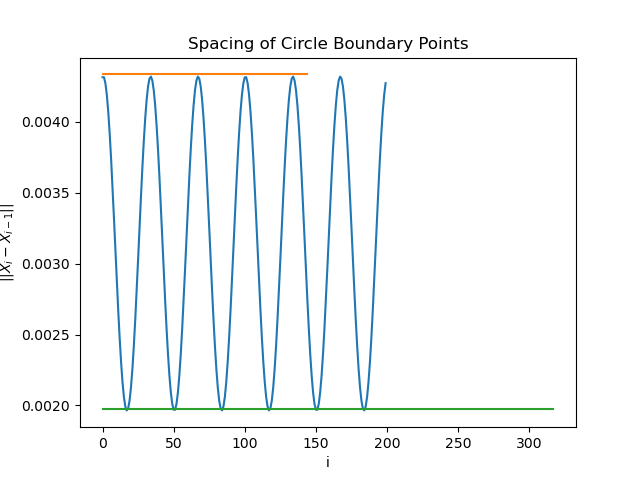

<IPython.core.display.Javascript object>


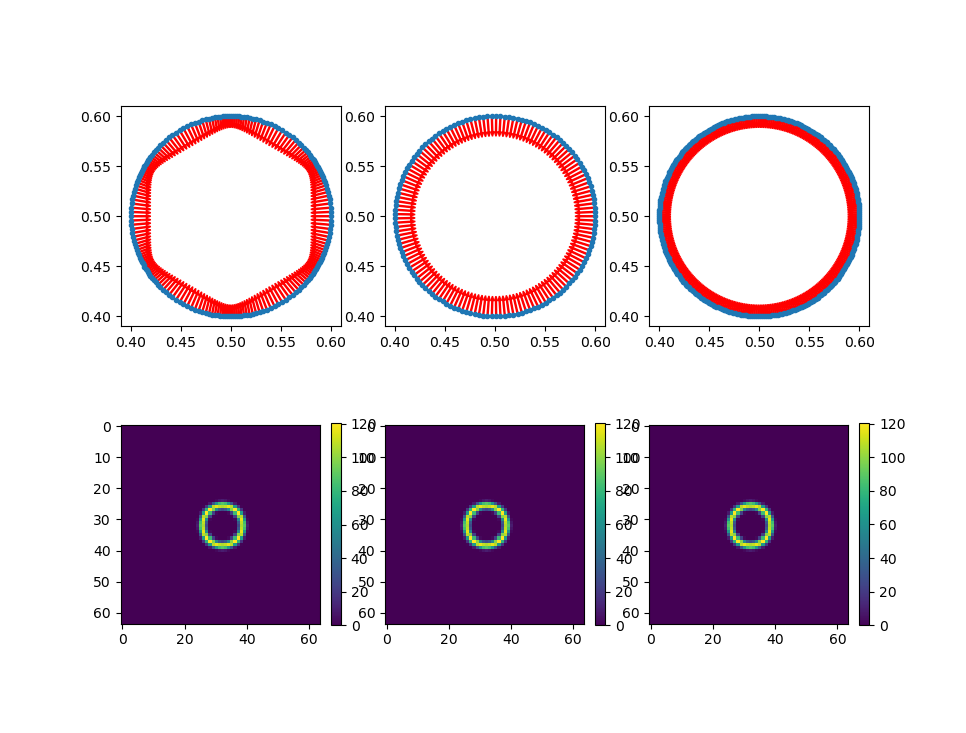

Maximum Force Density: 0.01552590864252369
Total Force on Fluid: 9204.926735287689

Maximum Force Density: 0.015598412046153826
Total Force on Fluid: 9204.664988261644

Maximum Force Density: 0.007112924266686623
Total Force on Fluid: 9205.235426557796



In [96]:
def NONUNIF_CIRCLE(RAD=1., POS=(0.,0.), Nb=100, modF=6):
    theta = np.linspace(0, 2*np.pi, Nb+1)[:-1]
    theta += 4*np.pi*np.sin(theta*modF)/(Nb+1)
    return RAD*np.stack([np.cos(theta), np.sin(theta)], axis=1) + POS



Nb=200
X1 = NONUNIF_CIRCLE(0.1, [0.5,0.5], Nb)
dNorm = lambda X: np.linalg.norm(X - X[np.arange(len(X))-1], axis=1)
dX1 = dNorm(X1)
X2 = CIRCLE(.1, [.5, .5], 145)#int(rad/(2*np.pi*min(dX1))))
X3 = CIRCLE(.1, [.5, .5], 318)##int(rad/(2*np.pi*max(dX1))))
plt.figure()
plt.plot(dX1)
plt.xlabel('i')
plt.ylabel('$||X_i - X_{i-1}||$')
plt.title('Spacing of Circle Boundary Points')
for X in X2, X3: plt.plot(dNorm(X))

    
    
XX = [X1, X2, X3]
ss = [IB2_AMR(X, fluid.N, fluid.h, fluid.dt, K=6) for X in XX]
fig = plt.figure()
f_non=[]
for i, s in enumerate(ss):
    ax = fig.add_subplot(2,3,i+1)
    ax2 = fig.add_subplot(2,3,i+4)
    f_non.append(plot_force(s, ax, ax2))
# s = IB2_AMR( X3, fluid.N, fluid.h, fluid.dt) 
# # s = IB2( MOD_CIRCLE(0.1, [0.5,0.5], 100, modA=modA, modF=f), fluid.N, fluid.h, fluid.dt, K=10) 
# ax = fig.add_subplot(1,2,1)
# ax2 = fig.add_subplot(1,2,2)
# f_non = plot_force(s, ax, ax2).copy()

We note that even though the force density on the fluid is the same in all three cases, the size of the arrows vary based on the local spacing of the points. In this case, boundary regions with large arrows have the same surface tension as those with small arrows, because there are fewer large arrows per unit length and vice versa.

<IPython.core.display.Javascript object>


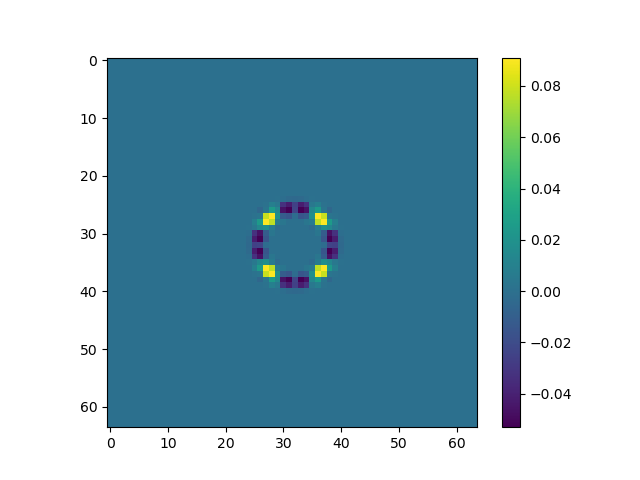

(64, 64)


In [174]:
fig = plt.figure()
# df = f_unif - f_non
df = f_non[0] - f_non[1]
print(np.shape(df))
c = plt.imshow(df)
plt.colorbar(c)

# Boundary Resolution and Local Refinement

We showed above that points which are spaced too far apart may give a partially-unresolved force on the fluid. Consequently, we need a technique for adding or subtracting boundary points. The simplest method is to simply add a vertex at the midpoint whenever an edge becomes too long, and to remove a vertex when an edge is too short. 

Note that adding vertices in this manner does not increase the total length of the boundary, and consequently does not change the energy of the boundary. Likewise, removing boundary points change the length of the boundary by at most ~ the length of the edge being removed - which is very small by definition.

In [105]:
def CIRCLE(RAD=1., POS=(0.,0.), Nb=100):  
    theta = np.linspace(0, 2*np.pi, Nb+1)[:-1]
    return RAD*np.stack([np.cos(theta), np.sin(theta)], axis=1) + POS

fluid = FLUID()
s = IB2_AMR(CIRCLE(.1, (.5, .5), Nb=10), fluid.N, fluid.L, fluid.dt)

<IPython.core.display.Javascript object>


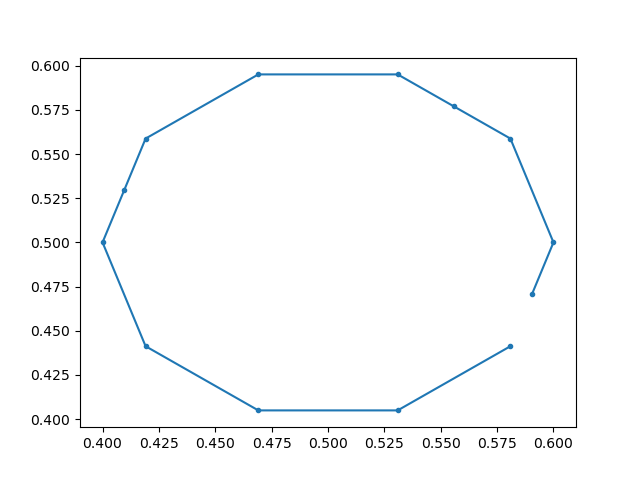

13


<IPython.core.display.Javascript object>


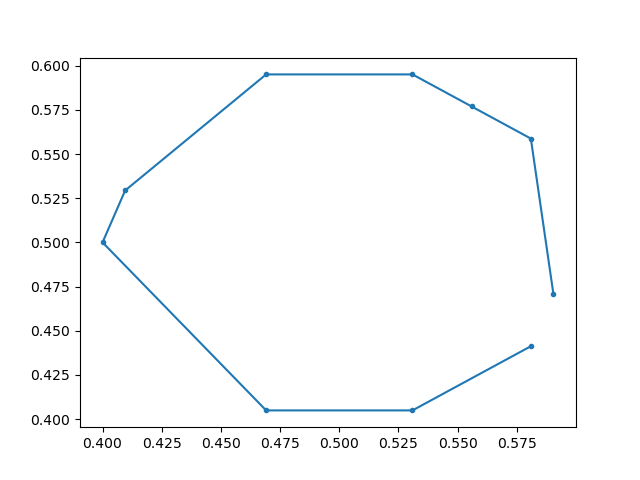

10
[[0.59045085 0.47061074]
 [0.5809017  0.55877853]
 [0.5559017  0.57694209]
 [0.5309017  0.59510565]
 [0.4690983  0.59510565]
 [0.40954915 0.52938926]
 [0.4        0.5       ]
 [0.4690983  0.40489435]
 [0.5309017  0.40489435]
 [0.5809017  0.44122147]]
10


<IPython.core.display.Javascript object>


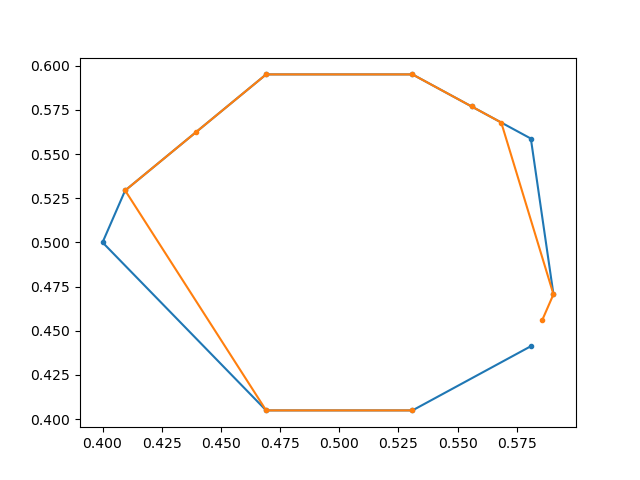

10
[[False False]
 [False False]
 [False False]
 [False False]
 [False  True]
 [False False]
 [False False]
 [False False]
 [False  True]
 [False False]]


In [106]:




s.split_X([0,2,5])

plt.figure()
plt.plot(s.X[:,0], s.X[:,1], marker='.')
plt.show()

print(s.Nb)


s.merge_X([1, 6, 9])

plt.figure()
plt.plot(s.X[:,0], s.X[:,1], marker='.')
plt.show()

print(s.Nb)
myx = s.X.copy()

print(s.X)
print(s.Nb)
plt.figure()
plt.plot(s.X[:,0], s.X[:,1], marker='.')
plt.show()


s.adj_X([0,2,5], [1,6,9])

plt.plot(s.X[:,0], s.X[:,1], marker='.')
plt.show()

print(s.Nb)
myx2 = s.X.copy()
print(myx2==myx)

# Time Evolution in a Stationary Fluid

Now let's iterate the fluid and boundary in time.



In [157]:
# Fluid Parameters
L = 1.0                 # Domain Length
N = 64                 # Domain Points (NxN grid)
mu = 0.01               # viscosity
dt = 0.01             # timestep
nsteps = 100            # simulation time 
nmod = 1               # save every nmod frames


# Immersed Body Parameters
K = 10.0
Nb = 100
rad=.1
pos=[0.5, 0.5]




#### Iterate fluids and immersed solids using built-in functions
def iterate(fluid, solids):   
    ff = 0.          ## Force density on fluid
    for solid in solids:
#         solid.XX=solid.X+(dt/2)*solid.interp(fluid.u,solid.X)  # Euler step to midpoint
#         F = solid.Force(solid.XX)
#         ff += solid.vec_spread(F,solid.XX)                     # Force at midpoint 
        solid.step_XX(fluid.u)                                   # equivalent built-in functions
        ff += solid.ff 
    uu=fluid.step_u(ff) # Step Fluid Velocity
    for solid in solids:
#         solid.X+=dt*solid.interp(uu,solid.XX) # full step using midpoint velocity         
        solid.step_X(uu)

def CIRCLE(RAD=1., POS=(0.,0.), Nb=100):  
    theta = np.linspace(0, 2*np.pi, Nb+1)[:-1]
    return RAD*np.stack([np.cos(theta), np.sin(theta)], axis=1) + POS


In [154]:
####################################
  ########   Simulation   ########
####################################

fluid = FLUID(N=N, L=L, mu=mu, dt=dt)
solids = [IB2_AMR( CIRCLE(rad, pos, Nb), fluid.N, fluid.h, fluid.dt, K=K)]
# solids = [IB2( CIRCLE(rad, pos, Nb), fluid.N, fluid.h, fluid.dt, K=10*K)]

#### Values that we're tracking
U = []
X = [[] for solid in solids]


dh = display('0', display_id=True)
# for i in range(nsteps+1):
for i in range(nsteps):
    iterate(fluid, solids)
    if i%nmod==0:
        
        dh.update(i)
        U.append(fluid.u.copy())
        for j, solid in enumerate(solids): X[j].append(solid.X.copy())
           

99

<IPython.core.display.Javascript object>


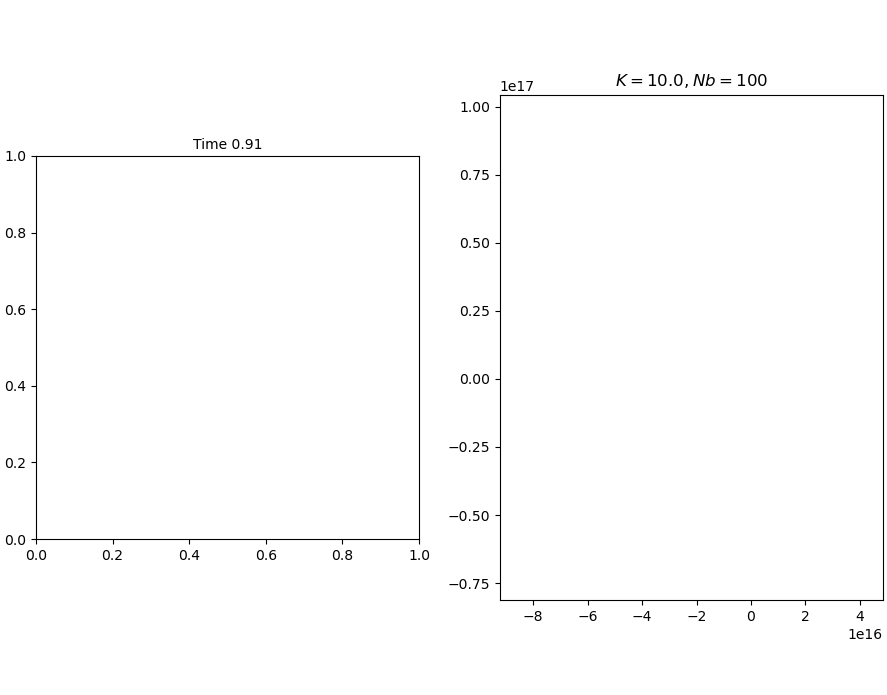

0
10
20
30
40
50
60
70
80
90


In [155]:
#### Animation
fig = plt.figure(constrained_layout=True)
nfigs = len(X)
gs = fig.add_gridspec(nfigs, nfigs+1)
ax = fig.add_subplot(gs[:, :-1])
ax.set_xlim([0, L])
ax.set_ylim([0, L])

axes_frame = [fig.add_subplot(gs[i, -1]) for i in range(nfigs)]
for j, axj in enumerate(axes_frame):
#     axj.set_title('$K={}, M={}, N_i={}$'.format(outsides[j].K, insides[j].M, len(insides[j].X)))
    axj.set_title('$K={}, Nb={}$'.format(K, Nb))
    axj.set_aspect('equal', 'box')
    
#     axj.set_xlim([-1, 1])
#     axj.set_ylim([-1, 1])
cmap = plt.get_cmap('tab10')
RED = plt.get_cmap('Reds')
ims = []

for i, u in enumerate(U):
    if i%10==0: print(i)
    im = [show_vorticity(u, L, ax)]
    out = show_streamlines(u, L, ax)
    im.append(out.lines)
    for j, axj in enumerate(axes_frame):
        x = X[j][i]
        im.append(ax.scatter(x[:,0]%L, x[:,1]%L, color=cmap(j)))
        im.append(ax.scatter(x[0,0]%L, x[0,1]%L, color='Red'))
        im.append(ax.text(0.5, 1.01, 'Time {}'.format(i*nmod*dt), horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes))

        #### Plot in COM Frame
        x0 = x - np.mean(x, axis=0)
        im.append(axj.scatter(x0[:,0], x0[:,1], color=cmap(1), s=1))
        im.append(axj.scatter([x0[0,0]], [x0[0,1]], color='red'))  ## Mark theta=0
    ims.append(im) 
        
#### Credit: Stack Exchange  https://stackoverflow.com/questions/61932534/cannot-remove-streamplot-arrow-heads-from-matplotlib-axes
from matplotlib import patches
for art in ax.get_children():
    if not isinstance(art, patches.FancyArrowPatch):
        continue
    art.remove()        # Method 1
    # art.set_alpha(0)  # Method 2  


    
    
# ani2 = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1)
# ani2.save('single_droplet.gif', writer='pillow')

In [156]:
ani2 = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1)


In [186]:
s = solids[0]
print(s.K)
print(s.Nb)
print(s.dtheta)

100.0
100
0.06283185307179587


(100,)
(200, 2)


<IPython.core.display.Javascript object>


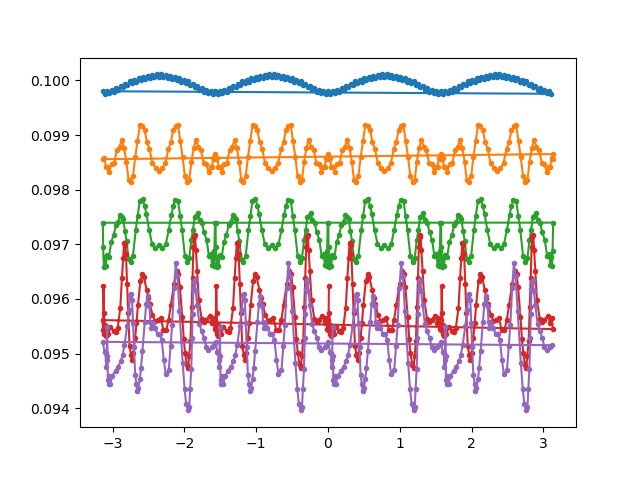

<IPython.core.display.Javascript object>


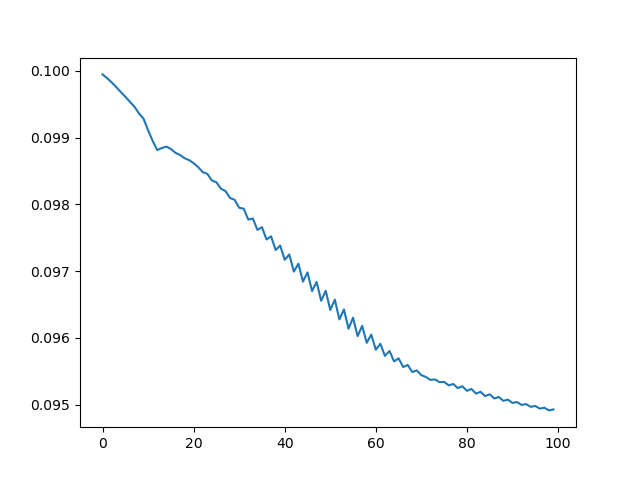

In [77]:
def get_theta(X): return np.arctan2(X[:,:,1], X[:,:,0])
def get_radii(X): return np.linalg.norm(X, axis=2)


X0 = [x - np.mean(x, axis=0)[np.newaxis, :] for x in X[0]]
print(np.shape(X0))
print(np.shape(X[0][0]))
R = [np.linalg.norm(x, axis=1) for x in X0]
th = [np.arctan2(x[:, 1], x[:, 0]) for x in X0]
plt.figure()
for i in range(0, len(R), 20): plt.plot(th[i], R[i], marker='.')
    
plt.figure()
plt.plot([np.mean(r) for r in R])

In [145]:
fig = plt.figure()
ax = fig.add_subplot()

IMS = []
for i in range(0, len(R)):  
    print(i)
    trash, trash, patches = ax.hist(th[i], color='blue',bins=np.linspace(0, np.pi, 20))
#     ims = ax.plot(i*np.arange(5))

#     ims = [ax.scatter(np.arange(5), i*np.arange(5))]
#     ims.append(ax.hist(th[i], color='blue',bins=np.linspace(0, np.pi, 20)))
#     IMS.append(ims)
    IMS.append(patches)


<IPython.core.display.Javascript object>

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [1]:
ani2 = animation.ArtistAnimation(fig, IMS, interval=150, repeat_delay=1)


NameError: name 'animation' is not defined

# Shrinking vs Time

- R(t)
Total Force (  (t)   )
vs   K


- How do forces scale vs springs?
- Is there an eq size?
- Does size depend on boundary spacing etc? How even does spacing need to be?

In [164]:
# Fluid Parameters
L = 1.0                 # Domain Length
N = 64                 # Domain Points (NxN grid)
mu = 0.01               # viscosity
dt = 0.01             # timestep
nsteps = 100          # simulation time 
nmod = 1               # save every nmod frames


# Immersed Body Parameters
K = 1.0
Nb = 100
rad=.25
pos=[0.5, 0.5]




#### Iterate fluids and immersed solids using built-in functions
def iterate(fluid, solids):   
    ff = 0.          ## Force density on fluid
    for solid in solids:
#         solid.XX=solid.X+(dt/2)*solid.interp(fluid.u,solid.X)  # Euler step to midpoint
#         F = solid.Force(solid.XX)
#         ff += solid.vec_spread(F,solid.XX)                     # Force at midpoint 
        solid.step_XX(fluid.u)                                   # equivalent built-in functions
        ff += solid.ff 
    uu=fluid.step_u(ff) # Step Fluid Velocity
    for solid in solids:
#         solid.X+=dt*solid.interp(uu,solid.XX) # full step using midpoint velocity         
        solid.step_X(uu)

def CIRCLE(RAD=1., POS=(0.,0.), Nb=100):  
    theta = np.linspace(0, 2*np.pi, Nb+1)[:-1]
    return RAD*np.stack([np.cos(theta), np.sin(theta)], axis=1) + POS


In [174]:
#### Shrinking vs Nb
Nb_vals = [50, 100, 150, 200, 250]
X = [[] for Nb in Nb_vals]
f = [[] for Nb in Nb_vals]

dh1 = display('--', display_id=True)
dh2 = display('--', display_id=True)
for ii, Nb in enumerate(Nb_vals):
    dh1.update('Nb={}'.format(Nb))
    fluid = FLUID(N=N, L=L, mu=mu, dt=dt)
#     solids=[IB2(CIRCLE(rad, pos, Nb), fluid.N, fluid.L, fluid.dt, K=K)]
    solids=[IB2_AMR(CIRCLE(rad, pos, Nb), fluid.N, fluid.h, fluid.dt, K=K)]
    
    for i in np.arange(nsteps):
        dh2.update('{}/{}'.format(i, nsteps))
        iterate(fluid, solids)
        X[ii].append(solids[0].X.copy())
        f[ii].append(np.sum(np.linalg.norm(solids[0].vec_spread(solids[0].Force(solids[0].X), solids[0].X), axis=0)))
        

'Nb=250'

'99/100'

<IPython.core.display.Javascript object>


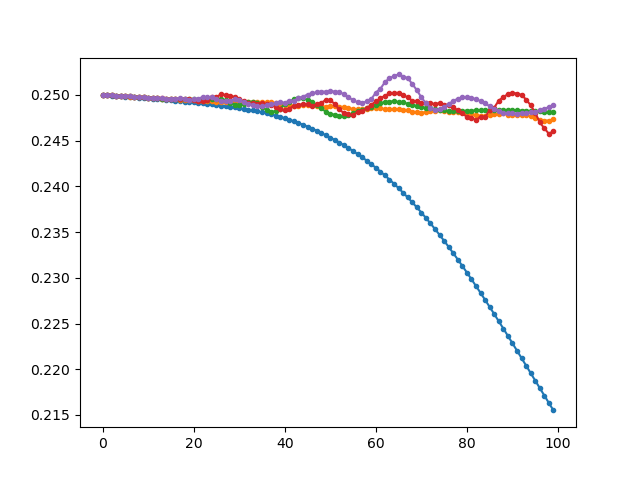

<IPython.core.display.Javascript object>


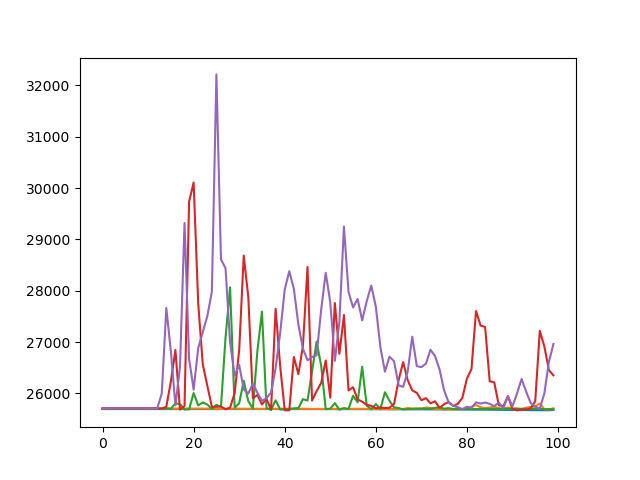

In [175]:
X0 = [ [x - np.mean(x, axis=0)[np.newaxis,:] for x in iX] for iX in X]

# plt.figure()
# for x in X0[1]: plt.scatter(*[x[:,i] for i in range(2)])
RR = [ [np.linalg.norm(x, axis=1) for x in iX] for iX in X0]

# print(np.shape(RR))
RR0 = [np.mean(r, axis=1) for r in RR]
# print(np.shape(RR0))
plt.figure()
for rr0 in RR0: plt.plot(rr0, marker='.')

plt.figure()
for frc in f: plt.plot(frc)

<IPython.core.display.Javascript object>


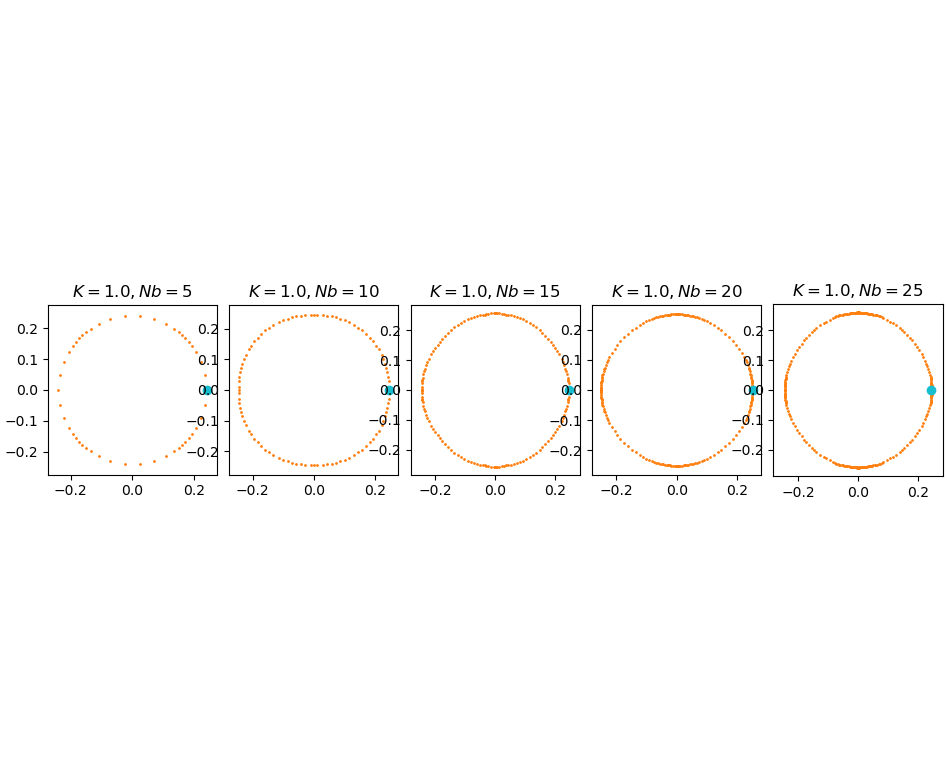

(5, 100)
5


90

In [177]:
#### Animation
fig = plt.figure(constrained_layout=True)
nfigs = len(X)
print(np.shape(X))
print(nfigs)


axes = [fig.add_subplot(1, nfigs, i+1) for i in range(nfigs)]
for j, axj in enumerate(axes):
#     axj.set_title('$K={}, M={}, N_i={}$'.format(outsides[j].K, insides[j].M, len(insides[j].X)))
    axj.set_title('$K={}, Nb={}$'.format(K, Nb_vals[j]))
    axj.set_aspect('equal', 'box')
    
#     axj.set_xlim([-1, 1])
#     axj.set_ylim([-1, 1])
cmap = plt.get_cmap('tab10')
RED = plt.get_cmap('Reds')
ims = []
dh = display('', display_id=True)
for i in range(len(X[0])):
    if i%10==0: dh.update(i)
    im=[]
    for j, axj in enumerate(axes):
        x = X[j][i]
        
        #### Plot in COM Frame
        x0 = x - np.mean(x, axis=0)
        im.append(axj.scatter(x0[:,0], x0[:,1], color=cmap(1), s=1))
        im.append(axj.scatter([x0[0,0]], [x0[0,1]], color=cmap(i)))  ## Mark theta=0
#         im.append(axj.scatter([x0[0,0]], [x0[0,1]], color='red'))  ## Mark theta=0
    ims.append(im) 
        

In [178]:
ani2 = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1)
# ani2.save('thing.gif', writer='pillow')

In [ ]:
def get_theta(X): return np.arctan2(X[:,:,1], X[:,:,0])
def get_radii(X): return np.linalg.norm(X, axis=2)


In [10]:
a = list(range(10))
a=np.array(a)
a[a>=5]+=1
a=list(a)
print(a)

[0, 1, 2, 3, 4, 6, 7, 8, 9, 10]


# Rigid Body

In [31]:
from rpib2 import RPIB2       #### 2D penalty IB object (droplet interior)

Kp = 5000
theta = np.pi/10
rad = 0.05
Ni = 100


####################################
  ########   Simulation   ########
####################################

#### Initialize Fluid+Droplets
fluid = FLUID(N=N, L=L, mu=mu)
fluid.dt = dt
# fluid.u[1] = 5.0
# # fluid.u[1] *= np.sin(np.linspace(0, 2*np.pi, N))[np.newaxis, :]
# fluid.u[1] *= np.linspace(0, 1, N)[np.newaxis, :]
insides = [RPIB2(SUNFLOWER(rad-fluid.h/2, positions[i], n=Ni), fluid.N, fluid.h, fluid.dt) for i in range(len(positions))]
solids = insides

#### Declare Forces
for inside in insides:
    inside.Kp = Kp    
    inside.M = M 
#     inside.bForce = lambda solid, Y: GRAV(solid, Y) - 1*solid.V + 100*TRAPPING_PLANE(Y, fluid.L)

    inside.bForce = lambda solid, Y:  GRAV(solid, Y, theta=theta) + Tamp*TRAPPING_PLANE(Y, fluid.L)*(1+np.sin(2*np.pi*fluid.t/(solid.dt*Tper)))
#     inside.bForce = lambda solid, Y:  0*GRAV(solid, Y, theta=theta)
    
#### Values that we're tracking
delta = [[] for inside in insides]    ## Keep track of |X-Y|/h
V = [[] for inside in insides]
LL = [[] for inside in insides]

U = []
Xin = [[] for inside in insides]
Y = [[] for inside in insides]
for i in range(nsteps+1):
    iterate(fluid, solids)
    #### Keeping track of 'interior' properties
    for j, iin in enumerate(insides):
        delta[j].append(np.max(np.linalg.norm(iin.Y - iin.X, axis=1)))
        V[j].append(np.mean(iin.V, axis=0))
        LL[j].append(iin.L)
    if i%nmod==0:
        print(i)
        U.append(fluid.u.copy())
        for j, iin in enumerate(insides):
            Xin[j].append(iin.X.copy())
            Y[j].append(iin.Y.copy())
            

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980
2000
2020
2040
2060
2080
2100
2120
2140
2160
2180
2200
2220
2240
2260
2280
2300
2320
2340
2360
2380
2400
2420
2440
2460
2480
2500


In [32]:
#### Animation
fig = plt.figure(constrained_layout=True)
nfigs = len(Xin)
gs = fig.add_gridspec(nfigs, nfigs+1)
ax = fig.add_subplot(gs[:, :-1])
ax.set_xlim([0, L])
ax.set_ylim([0, L])

axes_frame = [fig.add_subplot(gs[i, -1]) for i in range(nfigs)]
for j, axj in enumerate(axes_frame):
#     axj.set_title('$K={}, M={}, N_i={}$'.format(outsides[j].K, insides[j].M, len(insides[j].X)))
    axj.set_title('$K={}, M={}, N_i={}$'.format(K, M, Nb))
    
#     axj.set_xlim([-1, 1])
#     axj.set_ylim([-1, 1])
cmap = plt.get_cmap('tab10')
RED = plt.get_cmap('Reds')
ims = []

for i, u in enumerate(U):
    print(i*nmod)
    im = [show_vorticity(u, L, ax)]
    out = show_streamlines(u, L, ax)
    im.append(out.lines)
    for k, X in enumerate([Xin]):
        for j, x in enumerate(X): 
            im.append(ax.scatter(x[i][:,0]%L, x[i][:,1]%L, color=cmap(2*j+k)))
            im.append(ax.text(0.5, 1.01, 'Time {}'.format(i*nmod*dt), horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes))
    for j, axj in enumerate(axes_frame):
        #### Plot Droplets in COM Frame
        xin = Xin[j][i]
        com = np.mean(xin, axis=0)
        ins = xin - com

        im.append(axj.scatter(ins[:,0], ins[:,1], s=1000/Ni, color=cmap(0)))
#         im.append(axj.scatter([ins[-1,0]], [ins[-1,1]], color='red'))  ## Mark theta=0
        
        ### DEBUG ####
        yins = Y[j][i] - com
        im.append(axj.scatter(yins[:,0], yins[:,1], s=1000/Ni, color=cmap(1)))
        im.append(axj.scatter([yins[-1,0]], [yins[-1,1]], color='red'))  ## Mark theta=0
        
#         TETHERS = np.array([[ins[i], yins[i]] for i in range(len(ins))])
#         for tether in TETHERS:
#             im.extend(axj.plot(tether[:,0], tether[:,1], color=RED(np.linalg.norm(tether[1]-tether[0])*N/L)))
        
#         im.append(ax.set_title('t={}'.format(1*fluid.t)))

        ## Record theta profile of each boundary
#             THETA[j].append(np.arctan2(out[:,1], out[:,0]))


    ims.append(im) 
        
#### Credit: Stack Exchange  https://stackoverflow.com/questions/61932534/cannot-remove-streamplot-arrow-heads-from-matplotlib-axes
from matplotlib import patches
for art in ax.get_children():
    if not isinstance(art, patches.FancyArrowPatch):
        continue
    art.remove()        # Method 1
    # art.set_alpha(0)  # Method 2  


    
    
# ani2 = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1)
# ani2.save('single_droplet.gif', writer='pillow')

<IPython.core.display.Javascript object>

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980
2000
2020
2040
2060
2080
2100
2120
2140
2160
2180
2200
2220
2240
2260
2280
2300
2320
2340
2360
2380
2400
2420
2440
2460
2480
2500


In [33]:
ani3 = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1)

<IPython.core.display.Javascript object>


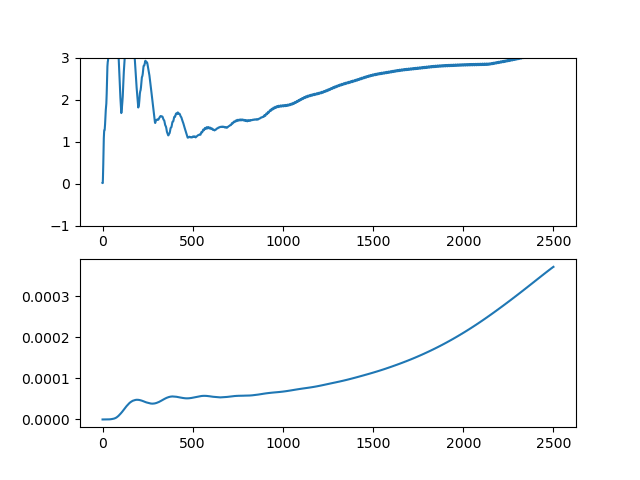

In [34]:
fig2 = plt.figure()
ax1 = fig2.add_subplot(2, 1, 1)
ax1.set_ylim([-1, 3])
for d in delta: ax1.plot(np.array(d)/fluid.h)
    
ax2 = fig2.add_subplot(2, 1, 2)       
for i in range(len(insides)): ax2.plot(0.5*dt*np.array(LL[i])/insides[i].I0)


Rigid Body Sedimentation Plotting Functions


In [ ]:
#### Animation
%matplotlib notebook 

fig = plt.figure(constrained_layout=True)
nfigs = len(Xin)
gs = fig.add_gridspec(nfigs, nfigs+1)
ax = fig.add_subplot(gs[:, :-1])
ax.set_xlim([0, L])
ax.set_ylim([0, L])

axes_frame = [fig.add_subplot(gs[i, -1]) for i in range(nfigs)]
for j, axj in enumerate(axes_frame):
#     axj.set_title('$K={}, M={}, N_i={}$'.format(outsides[j].K, insides[j].M, len(insides[j].X)))
    axj.set_title('$K={}, M={}, N_i={}$'.format(K, M, Nb))
    
#     axj.set_xlim([-1, 1])
#     axj.set_ylim([-1, 1])
cmap = plt.get_cmap('tab10')
RED = plt.get_cmap('Reds')
ims = []

for i, u in enumerate(U):
    print(i*nmod)
#     im = [show_vorticity(u, L, ax)]
    im = [ax.imshow(u[1].transpose(), origin='lower', extent=[0, L, 0, L])]
    out = show_streamlines(u, L, ax)
    im.append(out.lines)
    for k, X in enumerate([Xin]):
        for j, x in enumerate(X): 
            im.append(ax.scatter(x[i][:,0]%L, x[i][:,1]%L, color=cmap(2*j+k)))
            im.append(ax.text(0.5, 1.01, 'Time {}'.format(i*nmod*dt), horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes))
    for j, axj in enumerate(axes_frame):
        #### Plot Droplets in COM Frame
        xin = Xin[j][i]
        com = np.mean(xin, axis=0)
        ins = xin - com

        im.append(axj.scatter(ins[:,0], ins[:,1], s=1000/Ni, color=cmap(0)))
#         im.append(axj.scatter([ins[-1,0]], [ins[-1,1]], color='red'))  ## Mark theta=0
        
        ### DEBUG ####
        yins = Y[j][i] - com
        im.append(axj.scatter(yins[:,0], yins[:,1], s=1000/Ni, color=cmap(1)))
        im.append(axj.scatter([yins[-1,0]], [yins[-1,1]], color='red'))  ## Mark theta=0
        
#         TETHERS = np.array([[ins[i], yins[i]] for i in range(len(ins))])
#         for tether in TETHERS:
#             im.extend(axj.plot(tether[:,0], tether[:,1], color=RED(np.linalg.norm(tether[1]-tether[0])*N/L)))
        
#         im.append(ax.set_title('t={}'.format(1*fluid.t)))

        ## Record theta profile of each boundary
#             THETA[j].append(np.arctan2(out[:,1], out[:,0]))


    ims.append(im) 
        
#### Credit: Stack Exchange  https://stackoverflow.com/questions/61932534/cannot-remove-streamplot-arrow-heads-from-matplotlib-axes
from matplotlib import patches
for art in ax.get_children():
    if not isinstance(art, patches.FancyArrowPatch):
        continue
    art.remove()        # Method 1
    # art.set_alpha(0)  # Method 2  


    
    
# ani2 = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1)
# ani2.save('single_droplet.gif', writer='pillow')

In [ ]:
fig2 = plt.figure()
ax1 = fig2.add_subplot(3, 2, 1)
ax1.set_ylim([-1, 3])
ax1.set_title('Mass Marker Convergence')
ax1.set_ylabel('||X-Y||/h')
ax1.set_xlabel('Timestep')
for d in delta: ax1.plot(np.array(d)/fluid.h)
    
ax2 = fig2.add_subplot(3, 2, 2)       
ax2.set_title('Angular Velocity')
ax2.set_ylabel('$\omega$')
ax2.set_xlabel('Timestep')
for i in range(len(insides)): ax2.plot(0.5*dt*np.array(LL[i])/insides[i].I0)
    
ax3 = fig2.add_subplot(3, 2, 3)       
ax3.set_title('$Vx_{cm}$')
ax3.set_xlabel('Timestep')
for i in range(len(insides)): ax3.plot(np.array(VCM)[i][:, 0])

ax3 = fig2.add_subplot(3, 2, 4)       
ax3.set_title('$Vy_{cm}$')
ax3.set_xlabel('Timestep')
for i in range(len(insides)): ax3.plot(np.array(VCM)[i][:, 1])
    
ax3 = fig2.add_subplot(3, 2, 5)       
ax3.set_title('$X_{cm}$')
ax3.set_xlabel('Timestep')
for i in range(len(insides)): ax3.plot(np.array(YCM)[i][:, 0])

ax3 = fig2.add_subplot(3, 2, 6)       
ax3.set_title('$Y_{cm}$')
ax3.set_xlabel('Timestep')
for i in range(len(insides)): ax3.plot(np.array(YCM)[i][:, 1])
    
fig2.tight_layout()

In [ ]:
#### Animation
%matplotlib notebook
fig = plt.figure(constrained_layout=True)
nfigs = len(Xin)
gs = fig.add_gridspec(nfigs, nfigs+1)
ax = fig.add_subplot(gs[:, :-1])
ax.set_xlim([0, L])
ax.set_ylim([0, L])

axes_frame = [fig.add_subplot(gs[i, -1]) for i in range(nfigs)]
for j, axj in enumerate(axes_frame):
#     axj.set_title('$K={}, M={}, N_i={}$'.format(outsides[j].K, insides[j].M, len(insides[j].X)))
    axj.set_title('$K={}, M={}, N_i={}$'.format(K, M, Nb))
    
#     axj.set_xlim([-1, 1])
#     axj.set_ylim([-1, 1])
cmap = plt.get_cmap('tab10')
RED = plt.get_cmap('Reds')
ims = []

for i, u in enumerate(U):
    print(i*nmod)
    im = [show_vorticity(u, L, ax)]
    out = show_streamlines(u, L, ax)
    im.append(out.lines)
    for k, X in enumerate([Xin, Xout]):
        for j, x in enumerate(X): 
            im.append(ax.scatter(x[i][:,0]%L, x[i][:,1]%L, color=cmap(2*j+k)))
            im.append(ax.text(0.5, 1.01, 'Time {}'.format(i*nmod*dt), horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes))
    for j, axj in enumerate(axes_frame):
        #### Plot Droplets in COM Frame
        xin = Xin[j][i]
        xout = Xout[j][i]
        com = np.mean(xin, axis=0)
        ins = xin - com
        out = xout - com

        im.append(axj.scatter(ins[:,0], ins[:,1], s=1000/Ni, color=cmap(0)))
        im.append(axj.scatter(out[:,0], out[:,1], color=cmap(1)))
        im.append(axj.scatter([out[0,0]], [out[0,1]], color='red'))  ## Mark theta=0
        
        ### DEBUG ####
        yins = Y[j][i] - com
        im.append(axj.scatter(yins[:,0], yins[:,1], s=1000/Ni, color=cmap(1)))
#         TETHERS = np.array([[ins[i], yins[i]] for i in range(len(ins))])
#         for tether in TETHERS:
#             im.extend(axj.plot(tether[:,0], tether[:,1], color=RED(np.linalg.norm(tether[1]-tether[0])*N/L)))
        
        ## Record theta profile of each boundary
#             THETA[j].append(np.arctan2(out[:,1], out[:,0]))


    ims.append(im) 
        
#### Credit: Stack Exchange  https://stackoverflow.com/questions/61932534/cannot-remove-streamplot-arrow-heads-from-matplotlib-axes
from matplotlib import patches
for art in ax.get_children():
    if not isinstance(art, patches.FancyArrowPatch):
        continue
    art.remove()        # Method 1
    # art.set_alpha(0)  # Method 2  


    
    
# ani2 = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1)
# ani2.save('single_droplet.gif', writer='pillow')